In [1]:
import os
import sys
sys.path.append('../')
import glob2 as glob
import json
import requests
import numpy as np
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
#import plotly.express as px
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500
%matplotlib inline

import warnings; warnings.simplefilter('ignore')

In [2]:
# Sklearn stuff
from sklearn.model_selection import train_test_split

#from sklearn.linear_model import LogisticRegression
#from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.model_selection import ShuffleSplit, KFold

In [3]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [4]:
SEED = 17

In [5]:
#PATH_TO_DATA = '../input/'


# Import Training and Test Data  
train_features = pd.read_csv('data2/dpc_train_features.csv', index_col='match_id')
train_targets = pd.read_csv('data2/dpc_train_target.csv', index_col='match_id')
test_features = pd.read_csv('data2/dpc_test_features.csv', index_col='match_id')
test_targets = pd.read_csv('data2/dpc_test_target.csv', index_col='match_id')

In [11]:
# Combining training and test features for convenience so I can hot encode both at same time
all_features = pd.concat([train_features, test_features])
all_targets = pd.concat([train_targets, test_targets])

all_merged = pd.concat([all_targets, all_features], axis=1)

# Index to split the training and test data sets
idx_split = train_features.shape[0]
idx_split = train_targets.shape[0]

In [12]:
all_merged.head()

,radiant_win,duration,1is_pick,1team,1hero_id,2is_pick,2team,2hero_id,3is_pick,3team,3hero_id,4is_pick,4team,4hero_id,5is_pick,5team,5hero_id,6is_pick,6team,6hero_id,7is_pick,7team,7hero_id,8is_pick,8team,8hero_id,9is_pick,9team,9hero_id,10is_pick,10team,10hero_id,11is_pick,11team,11hero_id,12is_pick,12team,12hero_id,13is_pick,13team,13hero_id,14is_pick,14team,14hero_id,15is_pick,15team,15hero_id,16is_pick,16team,16hero_id,17is_pick,17team,17hero_id,18is_pick,18team,18hero_id,19is_pick,19team,19hero_id,20is_pick,20team,20hero_id,21is_pick,21team,21hero_id,22is_pick,22team,22hero_id
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5115031896,1,2069,1,0,25,1,1,66,1,0,60,1,1,90,1,0,7,1,1,96,1,0,85,1,1,102,1,1,6,1,0,52,1,0,13,1,1,19,1,0,46,1,1,98,1,1,86,1,0,20,1,1,72,1,0,77,1,1,23,1,0,112,1,0,129,1,1,2
4865407245,0,2524,1,1,71,1,0,18,1,1,55,1,0,66,1,1,129,1,0,96,1,1,37,1,0,121,1,0,103,1,1,100,1,1,106,1,0,104,1,1,16,1,0,76,1,0,65,1,1,8,1,0,46,1,1,57,1,0,114,1,1,10,1,1,17,1,0,42
4889341660,0,2151,1,1,105,1,0,107,1,1,121,1,0,80,1,1,86,1,0,66,1,1,57,1,0,18,1,0,111,1,1,95,1,1,96,1,0,11,1,1,55,1,0,52,1,0,79,1,1,27,1,0,2,1,1,85,1,0,17,1,1,35,1,1,76,1,0,43
5050335216,1,2484,1,0,84,1,1,90,1,0,19,1,1,79,1,0,60,1,1,23,1,0,103,1,1,96,1,1,86,1,0,106,1,0,61,1,1,10,1,0,93,1,1,41,1,1,37,1,0,9,1,1,72,1,0,76,1,1,16,1,0,39,1,0,108,1,1,59
4860032461,1,1958,1,1,111,1,0,18,1,1,69,1,0,55,1,1,65,1,0,8,1,1,66,1,0,121,1,0,16,1,1,107,1,1,42,1,0,46,1,1,10,1,0,54,1,0,37,1,1,96,1,0,106,1,1,76,1,0,95,1,1,82,1,1,1,1,0,73


In [14]:
data = all_merged

Let's make some variables. Will be drawing heavily from (https://github.com/codexponent/dota2-draft-analysis/blob/master/README.md)

In [16]:
# # Getting the wins of the second pick (i.e., the team that goes second in the sequential picking order)
temp = data.loc[data['1team'] == 0]
win1 = temp.loc[temp['radiant_win'] == False]

temp2 = data.loc[data['1team'] == 1]
win2 = temp2.loc[temp2['radiant_win'] == True]

In [18]:
# # Validation
win1.shape[0] + win2.shape[0] < len(data) #!!! Why is this true/ something to validate?

True

In [19]:
to_concat_dataframes = [win1, win2]
all_win_data_only = pd.concat(to_concat_dataframes)

In [20]:
all_win_data_only = all_win_data_only.sort_index()
all_win_data_only.head(3)

,radiant_win,duration,1is_pick,1team,1hero_id,2is_pick,2team,2hero_id,3is_pick,3team,3hero_id,4is_pick,4team,4hero_id,5is_pick,5team,5hero_id,6is_pick,6team,6hero_id,7is_pick,7team,7hero_id,8is_pick,8team,8hero_id,9is_pick,9team,9hero_id,10is_pick,10team,10hero_id,11is_pick,11team,11hero_id,12is_pick,12team,12hero_id,13is_pick,13team,13hero_id,14is_pick,14team,14hero_id,15is_pick,15team,15hero_id,16is_pick,16team,16hero_id,17is_pick,17team,17hero_id,18is_pick,18team,18hero_id,19is_pick,19team,19hero_id,20is_pick,20team,20hero_id,21is_pick,21team,21hero_id,22is_pick,22team,22hero_id
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4832621485,1,2404,1,1,46,1,0,112,1,1,111,1,0,88,1,1,91,1,0,37,1,1,16,1,0,121,1,0,65,1,1,52,1,1,18,1,0,57,1,1,54,1,0,104,1,0,81,1,1,102,1,0,55,1,1,69,1,0,94,1,1,61,1,1,43,1,0,82
4832849461,0,1417,1,0,112,1,1,91,1,0,88,1,1,37,1,0,57,1,1,121,1,0,16,1,1,111,1,1,46,1,0,97,1,0,42,1,1,81,1,0,18,1,1,95,1,1,86,1,0,87,1,1,52,1,0,8,1,1,15,1,0,54,1,0,106,1,1,38
4832947918,0,1394,1,0,112,1,1,91,1,0,88,1,1,37,1,0,52,1,1,121,1,0,46,1,1,111,1,1,55,1,0,18,1,0,106,1,1,16,1,0,15,1,1,57,1,1,71,1,0,79,1,1,17,1,0,27,1,1,29,1,0,65,1,0,96,1,1,42


In [21]:
all_win_data_only.shape

(552, 68)

In [17]:
#Hyperparameter Optimization (Cross Val Score)
validation_scores = []

C = [0.1, 1, 10, 100]

for value in C:
    logreg_hyper = LogisticRegression(C=value, random_state=1)
    
    cv_score = np.mean(cross_val_score(logreg_hyper, X_train, y_train, cv=5))
    
    validation_scores.append(cv_score)
    
    joblib.dump(validation_scores, 'validation_score.pkl')
    

In [18]:
#Load pkl file and plot the results
val_scores = joblib.load('validation_score.pkl')

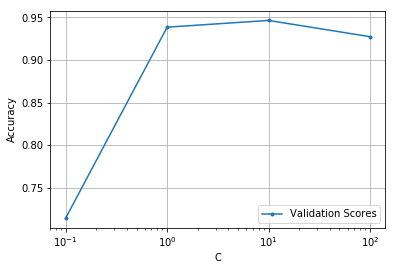

In [19]:
# and plot a figure of the train and test scores over time
plt.figure()
plt.plot(C, val_scores, label="Validation Scores", marker='.')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.grid()
plt.legend();
plt.show();